In [1]:
#libraries
library(magrittr)
library(gutenbergr)
library(tidyverse)
library(tidytext)
library(quanteda)
library(quanteda.textstats)

── Attaching packages ────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ───────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
Package version: 3.2.4
Unicode version: 13.0
ICU version: 69.1

Parallel computing: 8 of 8 threads used.

See https://quanteda.io for tutorials and examples.



In [2]:
#downloading books
g <- gutenberg_metadata
v <- gutenberg_download(c(8119, 27081))

books <- g[g$gutenberg_id %in% c(8119, 27081),c("gutenberg_id","title")]

v %<>% left_join(books) %>%
  mutate(gutenberg_id = NULL)

#stop words
stops <- read.table("https://jsienkiewicz.pl/TEXT/lab/stopw.dat", stringsAsFactors = F)
stops <- tibble(word = stops$V1) 
stops <- stops %>% #dodaje też inne słowa które znalazły się przypadkiem
#czy byłaby może lepsza metoda? np usunięcie pierwszych x wierszów tibble? jesli tak to jak?
#zakładając że mamy v składające się z dwóch książek
  add_row(tibble_row(word = "gutenberg")) %>%
  add_row(tibble_row(word = "project")) %>%
  add_row(tibble_row(word = "tm")) %>%
  add_row(tibble_row(word = "electronic")) %>%
  add_row(tibble_row(word = "united")) %>%
  add_row(tibble_row(word = "states")) %>%
  add_row(tibble_row(word = "literary")) %>%
  add_row(tibble_row(word = "archive")) %>%
  add_row(tibble_row(word = "1")) %>%
  add_row(tibble_row(word = "paragraph")) %>%
  add_row(tibble_row(word = "terms")) %>%
  add_row(tibble_row(word = "agreement")) %>%
  add_row(tibble_row(word = "www")) %>%
  add_row(tibble_row(word = "org")) 


df <- v %>% 
  unnest_tokens(word, text) %>% 
  anti_join(stops) %>%
  group_by(title) %>% 
  summarise(text = paste(word, collapse = " ")) %>%
  corpus()
  
summary(df)

Determining mirror for Project Gutenberg from http://www.gutenberg.org/robot/harvest

Using mirror http://aleph.gutenberg.org

Joining, by = "gutenberg_id"
Joining, by = "word"


,Text,Types,Tokens,Sentences,title
,<chr>,<int>,<int>,<int>,<chr>
1,text1,10882,19472,1,Sklepy cynamonowe
2,text2,2657,3460,1,Sonety Adama Mickiewicza


In [3]:
#creating bigrams
#dla Sonetów
df.dfm <- df %>% 
  corpus_subset(title == books$title[2]) %>%
  tokens(remove_punct = T) %>%
  tokens_remove(stopwords("english")) %>% #deleting stop words in description of books
  tokens_ngrams(concatenator = " ") %>%
  dfm()

df.dfm %>%
  textstat_frequency(n = 20)
#dla Domów
df.dfm <- df %>% 
  corpus_subset(title == books$title[1]) %>%
  tokens(remove_punct = T) %>%
  tokens_remove(stopwords("english")) %>% #deleting stop words in description of books
  tokens_ngrams(concatenator = " ") %>%
  dfm()

df.dfm %>%
  textstat_frequency(n = 20)

,feature,frequency,rank,docfreq,group
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,для императорской,2,1,1,all
2,s petrarki,2,1,1,all
3,niemnie domowa,2,1,1,all
4,domowa rzeko,2,1,1,all
5,chcę widzieć,2,1,1,all
6,d d,2,1,1,all
7,śród fali,2,1,1,all
8,ostrowy burzanu,2,1,1,all
9,pielgrzym mirza,2,1,1,all


,feature,frequency,rank,docfreq,group
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,wś ród,27,1,1,all
2,mego ojca,11,2,1,all
3,full license,9,3,1,all
4,set forth,8,4,1,all
5,sklepy cynamonowe,7,5,1,all
6,traktat manekinach,6,6,1,all
7,dnia dzień,5,7,1,all
8,ś ciany,5,7,1,all
9,uś miechem,5,7,1,all


Saving 7 x 7 in image


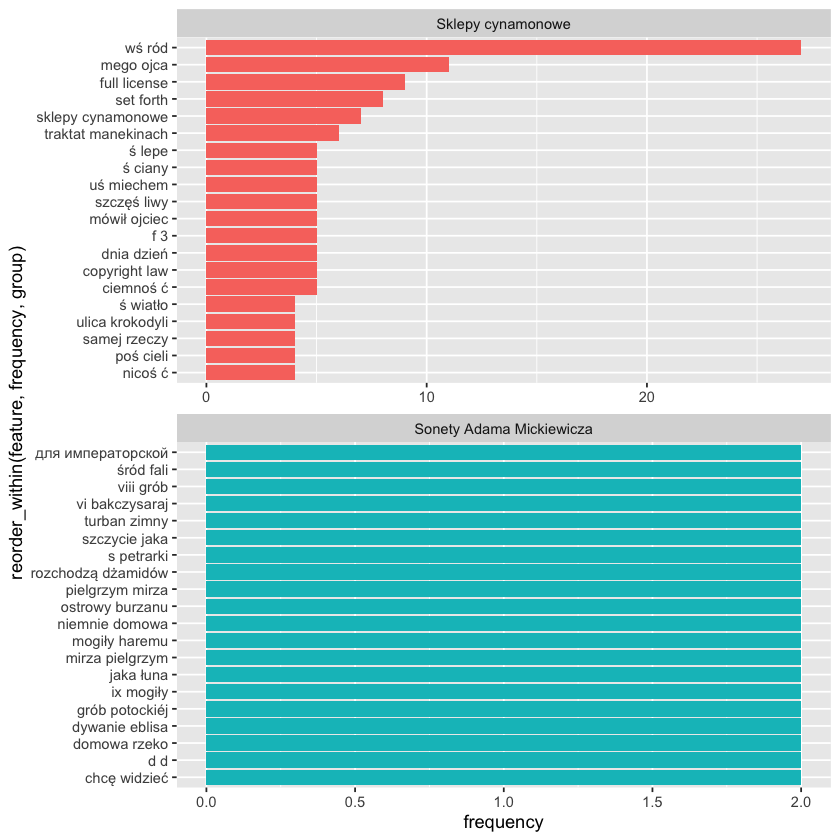

In [4]:
quartz()

gg <- df %>% 
  tokens(remove_punct = T) %>%
  tokens_remove(stopwords("english")) %>%
  tokens_ngrams(concatenator = " ") %>%
  dfm() %>%
  textstat_frequency(n = 20, groups = title) %>%
  ggplot() + 
  geom_col(aes(x = frequency, y = reorder_within(feature, frequency, group), fill = group), show.legend = F) + 
  facet_wrap(~group, scales = "free", nrow = 2) + 
  scale_y_reordered()

gg
ggsave(file="bigrams.png", gg)

Otrzyman wyniki nie mają zbyt dużej wartości w przypadku Sonetów (jako że są to Sonety, pewne powtórzenia bigramów mogą się w nich zdażyć), dla domów cynamonowych wyniki praktycznie są bez znaczenia. Spróbójmy ponownie, pozostawiając stop words tym razem

In [5]:
df1 <- v %>% 
  unnest_tokens(word, text) %>% 
  # anti_join(stops) %>%
  group_by(title) %>% 
  summarise(text = paste(word, collapse = " ")) %>%
  corpus()
  
summary(df1)

#creating bigrams
df1.dfm <- df %>% 
  corpus_subset(title == books$title[2]) %>%
  tokens(remove_punct = T) %>%
  tokens_remove(stopwords("english")) %>% #deleting stop words in description of books
  tokens_ngrams(concatenator = " ") %>%
  dfm()

df1.dfm %>%
  textstat_frequency(n = 20)

,Text,Types,Tokens,Sentences,title
,<chr>,<int>,<int>,<int>,<chr>
1,text1,11119,28453,1,Sklepy cynamonowe
2,text2,2826,4962,1,Sonety Adama Mickiewicza


,feature,frequency,rank,docfreq,group
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,для императорской,2,1,1,all
2,s petrarki,2,1,1,all
3,niemnie domowa,2,1,1,all
4,domowa rzeko,2,1,1,all
5,chcę widzieć,2,1,1,all
6,d d,2,1,1,all
7,śród fali,2,1,1,all
8,ostrowy burzanu,2,1,1,all
9,pielgrzym mirza,2,1,1,all


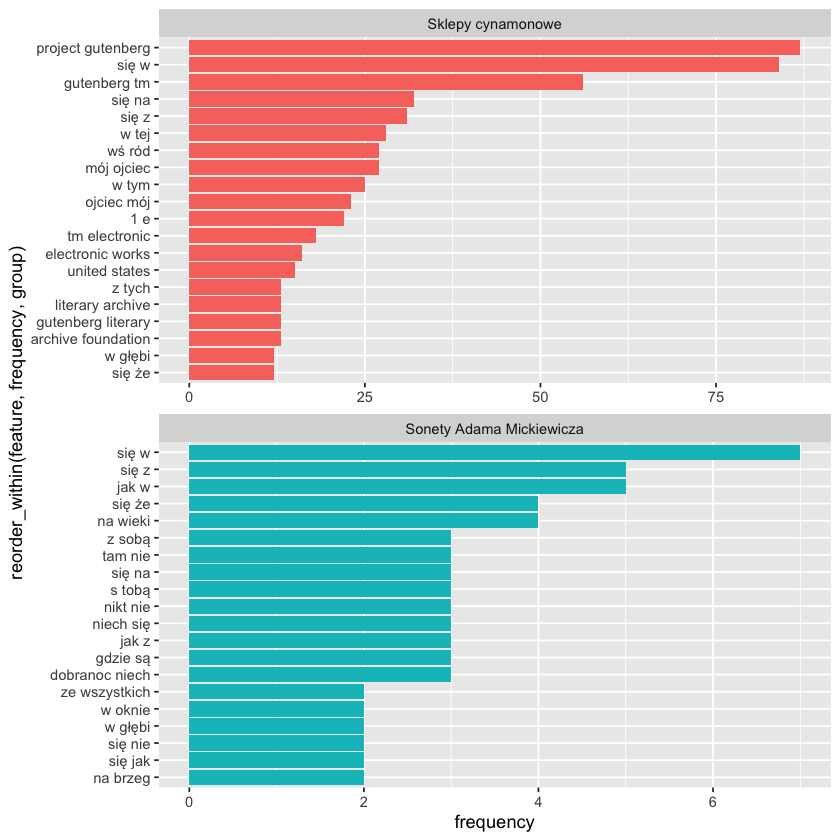

In [6]:
quartz()

df1 %>% 
  tokens(remove_punct = T) %>%
  tokens_remove(stopwords("english")) %>%
  tokens_ngrams(concatenator = " ") %>%
  dfm() %>%
  textstat_frequency(n = 20, groups = title) %>%
  ggplot() + 
  geom_col(aes(x = frequency, y = reorder_within(feature, frequency, group), fill = group), show.legend = F) + 
  facet_wrap(~group, scales = "free", nrow = 2) + 
  scale_y_reordered()

Ponownie wyniki dla Sklepów Cynamonowych nie mają większego sensu, Sonety w poprzedniej wersji sprawdzały się lepiej. Sieci wykreślę dla Sonetów bez usuwania stop words polskich

In [7]:
#sieci wyrazów
library(igraph)
library(ggraph)

#dla sonetów

mi.freq <- df %>% 
  corpus_subset(title == books$title[2]) %>%
  tokens(remove_punct = T) %>%
  tokens_remove(stopwords("english")) %>%
  tokens_ngrams(concatenator = " ") %>%
  dfm() %>%
  textstat_frequency()

bigram.sep <- as_tibble(mi.freq) %>% 
  separate(feature, c("word1", "word2"), " ")

graph.bi <- bigram.sep %>% 
  select(!(rank:group)) %>%
  top_n(20) %>%
  graph_from_data_frame()


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Selecting by frequency


Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”
Saving 7 x 7 in image


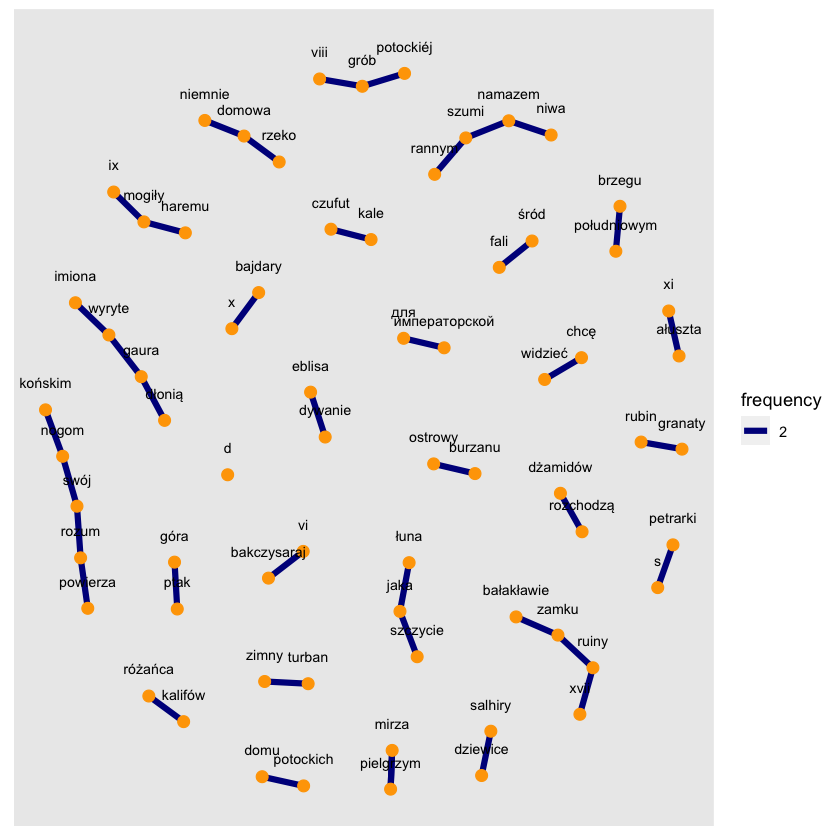

In [8]:
quartz()

gg <- ggraph(graph.bi, layout = "nicely") + 
  geom_edge_link(aes(width = frequency), color = "darkblue") + 
  scale_edge_width_continuous(range = c(0.5,3)) +
  geom_node_point(size = 3, color = "orange") +
  geom_node_text(aes(label = name), size = 3, nudge_y = 0.5)
gg
ggsave(file="word_nets_Sonety.png", gg)

Selecting by frequency
Saving 7 x 7 in image


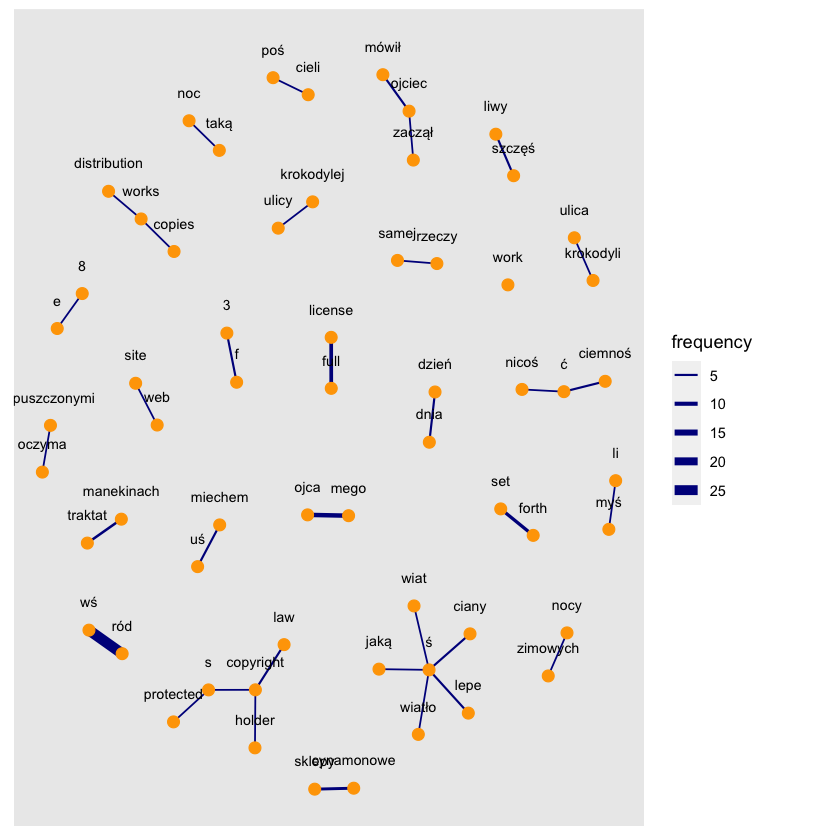

In [10]:

#dla Domów

mi.freq <- df %>% 
  corpus_subset(title == books$title[1]) %>%
  tokens(remove_punct = T) %>%
  tokens_remove(stopwords("english")) %>%
  tokens_ngrams(concatenator = " ") %>%
  dfm() %>%
  textstat_frequency()

bigram.sep <- as_tibble(mi.freq) %>% 
  separate(feature, c("word1", "word2"), " ")

graph.bi <- bigram.sep %>% 
  select(!(rank:group)) %>%
  top_n(20) %>%
  graph_from_data_frame()

quartz()

gg <- ggraph(graph.bi, layout = "nicely") + 
  geom_edge_link(aes(width = frequency), color = "darkblue") + 
  scale_edge_width_continuous(range = c(0.5,3)) +
  geom_node_point(size = 3, color = "orange") +
  geom_node_text(aes(label = name), size = 3, nudge_y = 0.5)
gg
ggsave(file="word_nets_Domy.png", gg)